# Neural Network Extension

In [44]:
from sklearn.datasets import load_digits 
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
import numpy as np
import numpy.random as r
import matplotlib.pyplot as plt 

# Creating the neural network

### The activation function and its derivative

We will use the sigmoid activation function:  $f(z)=\frac{1}{1+e^{-z}}$

The deriviative of the sigmoid function is: $f'(z) = f(z)(1-f(z))$ 

In [46]:
def f(z):
    return 1 / (1 + np.exp(-z))

def f_deriv(z):
    return f(z) * (1 - f(z))

### Creating and initialing W and b
We want the weights in W to be different so that during back propagation the nodes on a level will have different gradients and thus have different update values.

We want the  weights to be small values, since the sigmoid is almost "flat" for large inputs.

Next is the code that assigns each weight a number uniformly drawn from $[0.0, 1.0)$.  The code assumes that the number of neurons in each level is in the python list *nn_structure*.

In the code, the weights, $W^{(\ell)}$ and $b^{(\ell)}$ are held in a python dictionary

In [47]:
def setup_and_init_weights(nn_structure):
    W = {} #creating a dictionary i.e. a set of key: value pairs
    b = {}
    for l in range(1, len(nn_structure)):
        a = np.sqrt(6 / (nn_structure[l] + nn_structure[l-1]))
        W[l] = 2*a* r.random_sample((nn_structure[l], nn_structure[l-1])) - a #Return “continuous uniform” random floats in the half-open interval [0.0, 1.0). 
        b[l] = 2*a* r.random_sample((nn_structure[l],)) - a
    return W, b

### Initializing $\triangledown W$ and $\triangledown b$
Creating $\triangledown W^{(\ell)}$ and $\triangledown b^{(\ell)}$ to have the same size as $W^{(\ell)}$ and $b^{(\ell)}$, and setting $\triangledown W^{(\ell)}$, and  $\triangledown b^{(\ell)}$ to zero

In [48]:
def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b

## Feed forward
Perform a forward pass throught the network.  The function returns the values of $a$ and $z$

In [49]:
def feed_forward(x, W, b):
    a = {1: x} # create a dictionary for holding the a values for all levels
    z = { } # create a dictionary for holding the z values for all the layers
    for l in range(1, len(W) + 1): # for each layer
        node_in = a[l]
        z[l+1] = W[l].dot(node_in) + b[l]  # z^(l+1) = W^(l)*a^(l) + b^(l)
        a[l+1] = f(z[l+1]) # a^(l+1) = f(z^(l+1))
    return a, z

## Compute $\delta$
The code below compute $\delta^{(s_l)}$ in a function called "calculate_out_layer_delta",  and  computes $\delta^{(\ell)}$ for the hidden layers in the function called "calculate_hidden_delta".  

If we wanted to have a different cost function, we would change the "calculate_out_layer_delta" function.


In [50]:
def calculate_out_layer_delta(y, a_out, z_out):
    # delta^(nl) = -(y_i - a_i^(nl)) * f'(z_i^(nl))
    return -(y-a_out) * f_deriv(z_out)


def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l)

## Initialize hw and hb for Ada Grad

In [51]:
def init_h_w_b_values(nn_structure):
    h_w = {}
    h_b = {}
    for l in range(1, len(nn_structure)):
        h_w[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        h_b[l] = np.zeros((nn_structure[l],))
    return h_w, h_b

## The Back Propagation Algorithm


In [52]:
def train_nn(nn_structure, X, y, iter_num, alpha, lamb):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    N = len(y)
    avg_cost_func = []
    print('Starting gradient descent for {} iterations'.format(iter_num))
    h_w, h_b = init_h_w_b_values(nn_structure)
    while cnt < iter_num:
        if cnt%1000 == 0:
            print('Iteration {} of {}'.format(cnt, iter_num))
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0
        for i in range(N):
            delta = {}
            # perform the feed forward pass and return the stored a and z values, to be used in the
            # gradient descent step
            a, z = feed_forward(X[i, :], W, b)
            # loop from nl-1 to 1 backpropagating the errors
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i,:], a[l], z[l])
                    avg_cost += np.linalg.norm((y[i,:]-a[l]))
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                    # triW^(l) = triW^(l) + delta^(l+1) * transpose(a^(l))
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(a[l][:,np.newaxis]))# np.newaxis increase the number of dimensions
                    # trib^(l) = trib^(l) + delta^(l+1)
                    tri_b[l] += delta[l+1]
        # perform the gradient descent step for the weights in each layer
        for l in range(len(nn_structure) - 1, 0, -1):
            h_w[l] += tri_W[l] * tri_W[l]
            h_b[l] += tri_b[l] * tri_b[l]
            
            W[l] += -alpha * (tri_W[l] + lamb/2*W[l])/(np.sqrt(h_w[l]) + 1e-7)
            b[l] += -alpha * (tri_b[l]/(np.sqrt(h_b[l]) + 1e-7))
        # complete the average cost calculation
        # Remain the 
        avg_cost = 1.0/N * avg_cost 
        avg_cost_func.append(avg_cost)
        cnt += 1
    return W, b, avg_cost_func


def predict_y(W, b, X, n_layers):
    N = X.shape[0]
    y = np.zeros((N,))
    for i in range(N):
        a, z = feed_forward(X[i, :], W, b)
        y[i] = np.argmax(a[n_layers])
    return y

### One hot encoding
Our target is an integer in the range [0,..,9], so we will have 10 output neuron's in our network.  

-  If  $y=0$, we want the output neurons to have the values $(1,0,0,0,0,0,0,0,0,0)$

-  If  $y=1$ we want the output neurons to have the values $(0,1,0,0,0,0,0,0,0,0)$
-  etc

Thus we need to change our target so it is the same as our hoped for output of the neural network.  
-  If $y=0$ we change it into the vector $(1,0,0,0,0,0,0,0,0,0)$. 
-  If $y=1$ we change it into the vector $(0,1,0,0,0,0,0,0,0,0)$
-  etc

See page 29 from the website listed above

The code to covert the target vector.

In [45]:
def convert_y_to_vect(y, num_class):
    y_vect = np.zeros((len(y), num_class))
    for i in range(len(y)):
        y_vect[i, y[i]] = 1
    return y_vect

# Test on Handwritten Digits data

In [53]:
digits=load_digits()
X = digits.data
y = digits.target

X_scale = StandardScaler()
X = X_scale.fit_transform(digits.data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

y_v_train = convert_y_to_vect(y_train, 10)
y_v_test = convert_y_to_vect(y_test, 10)


nn_structure = [64, 30, 10]
    
# train the NN
alpha = 0.25
lamb = 0.01
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000, alpha, lamb)

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


### Plotting the learning curve for handwritten digits data for Adagrad


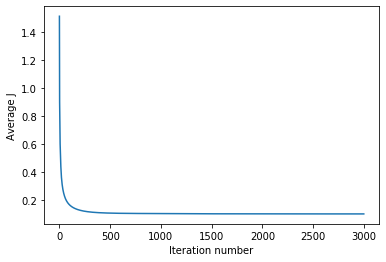

In [39]:
# plot the avg_cost_func
plt.plot(avg_cost_func)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()

### Prediction accuracy for handwritten digits data for Adagrad

In [40]:
# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3)
print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Prediction accuracy is 97.63560500695411%


# Test on Iris data

In [55]:
iris = load_iris()
X = iris.data
y = iris.target

X_scale = StandardScaler()
X = X_scale.fit_transform(iris.data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

y_v_train = convert_y_to_vect(y_train, 3)
y_v_test = convert_y_to_vect(y_test, 3)

nn_structure = [4, 30, 3]

alpha = 0.25
lamb = 0.01
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000, alpha, lamb)

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


### Plotting the learning curve for iris data for Adagrad

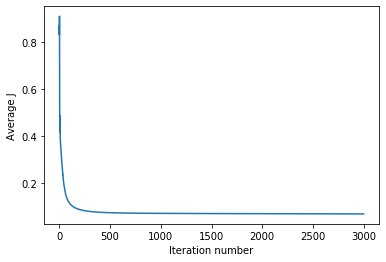

In [56]:
# plot the avg_cost_func
plt.plot(avg_cost_func)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()

### Prediction accuracy for iris data for Adagrad

In [57]:
# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3)
print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Prediction accuracy is 96.66666666666667%
